**Data Fetcher and Preprocessing**

In [ ]:
import os
import time
import math
import requests
import pandas as pd

# Create directories to store satellite images if they do not already exist
os.makedirs("images/train", exist_ok=True)
os.makedirs("images/test", exist_ok=True)


def latlon_to_tile(lat, lon, zoom):
    """
    Converts latitude and longitude into x, y tile coordinates

    """
    lat_rad = math.radians(lat)
    n = 2.0 ** zoom

    xtile = int((lon + 180.0) / 360.0 * n)
    ytile = int(
        (1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi)
        / 2.0 * n
    )
    return xtile, ytile


def download_image(lat, lon, save_path, zoom=18):
    """
    Downloads a satellite image tile for a given latitude and longitude
    by requesting data from the publicly available ArcGIS World Imagery
    tile service.
    """
    x, y = latlon_to_tile(lat, lon, zoom)

    url = (
        "https://services.arcgisonline.com/ArcGIS/rest/services/"
        f"World_Imagery/MapServer/tile/{zoom}/{y}/{x}"
    )

    r = requests.get(url, timeout=10)

    if r.status_code == 200:
        with open(save_path, "wb") as f:
            f.write(r.content)
        return True
    else:
        print("Failed to download tile. Status code:", r.status_code)
        return False


def process_dataset(csv_path, image_folder):
    """
    Reads a CSV file containing latitude and longitude information
    and downloads the corresponding satellite images for each entry.
    """
    df = pd.read_csv(csv_path)
    os.makedirs(image_folder, exist_ok=True)

    for idx, row in df.iterrows():
        save_path = os.path.join(image_folder, f"{row['id']}.png")

        # Skip downloading if the image already exists locally
        if os.path.exists(save_path):
            continue

        download_image(row["lat"], row["long"], save_path)

        # Add a small delay to avoid sending too many requests at once
        time.sleep(0.2)

        if idx % 50 == 0:
            print("Processed", idx)


if __name__ == "__main__":
    # Download satellite images for training and test datasets
    process_dataset("train.csv", "images/train")
    process_dataset("test.csv", "images/test")


Processed 0
Processed 50
Processed 100
Processed 150
Processed 200
Processed 250
Processed 300
Processed 350
Processed 400
Processed 450
Processed 500
Processed 550
Processed 600
Processed 650
Processed 700
Processed 750
Processed 800
Processed 850
Processed 900
Processed 950
Processed 1000
Processed 1050
Processed 1100
Processed 1150
Processed 1200
Processed 1250
Processed 1300
Processed 1350
Processed 1400
Processed 1450
Processed 1500
Processed 1550
Processed 1600
Processed 1650
Processed 1700
Processed 1750
Processed 1800
Processed 1850
Processed 1900
Processed 1950
Processed 2000
Processed 2050
Processed 2100
Processed 2150
Processed 2200
Processed 2250
Processed 2300
Processed 2350
Processed 2400
Processed 2450
Processed 2500
Processed 2550
Processed 2600
Processed 2650
Processed 2700
Processed 2750
Processed 2800
Processed 2850
Processed 2900
Processed 2950
Processed 3000
Processed 3050
Processed 3100
Processed 3150
Processed 3200
Processed 3250
Processed 3300
Processed 3350
Pro

In [ ]:
import os

print("Train images:", len(os.listdir("images/train")))
print("Test images:", len(os.listdir("images/test")))

Train images: 16110
Test images: 5396


**Exploratory Data Analysis**

In [ ]:
import pandas as pd
# Load the training dataset to inspect its structure and size
df = pd.read_csv("train.csv")

print("Shape of data:", df.shape)
df.head()

Shape of data: (16209, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


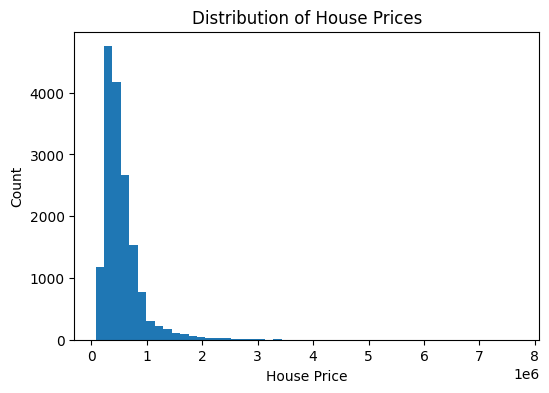

In [ ]:
import matplotlib.pyplot as plt

# Visualize the distribution of house prices to understand skewness and outliers
plt.figure(figsize=(6,4))
plt.hist(df["price"], bins=50)
plt.xlabel("House Price")
plt.ylabel("Count")
plt.title("Distribution of House Prices")
plt.show()

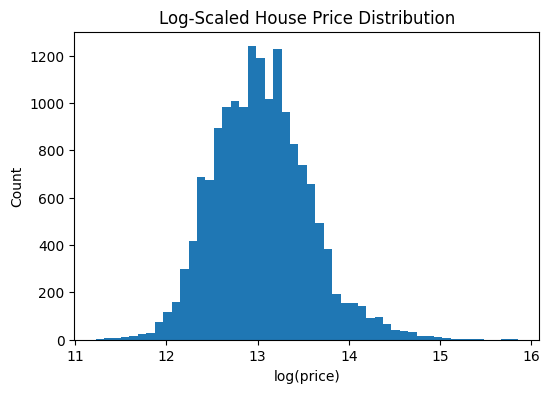

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Apply log scaling to reduce skewness and better visualize price distribution
plt.figure(figsize=(6,4))
plt.hist(np.log1p(df["price"]), bins=50)
plt.xlabel("log(price)")
plt.ylabel("Count")
plt.title("Log-Scaled House Price Distribution")
plt.show()

In [ ]:
low = df["price"].quantile(0.2)
high = df["price"].quantile(0.8)

# Sample properties from the bottom 20% and top 20% of prices
cheap_df = df[df["price"] <= low].sample(5, random_state=42)
expensive_df = df[df["price"] >= high].sample(5, random_state=42)

In [ ]:
from PIL import Image

# Display satellite images corresponding to selected properties
def show_images(rows, title):
    plt.figure(figsize=(15, 3))
    for i, (_, row) in enumerate(rows.iterrows()):
        img_path = f"images/train/{row['id']}.png"
        img = Image.open(img_path)

        plt.subplot(1, len(rows), i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"id={row['id']}")
    plt.suptitle(title)
    plt.show()

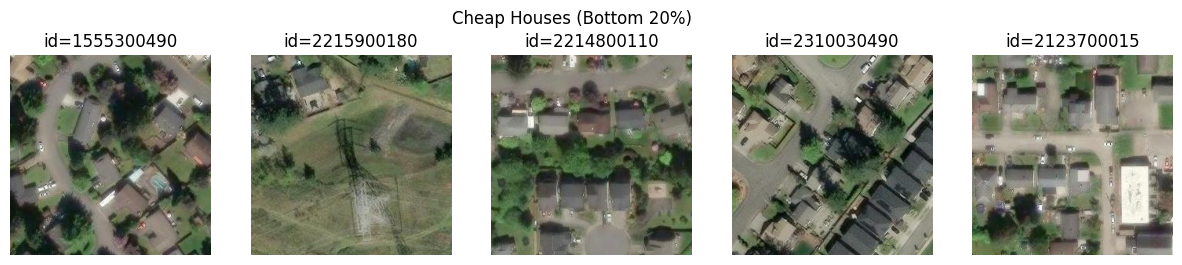

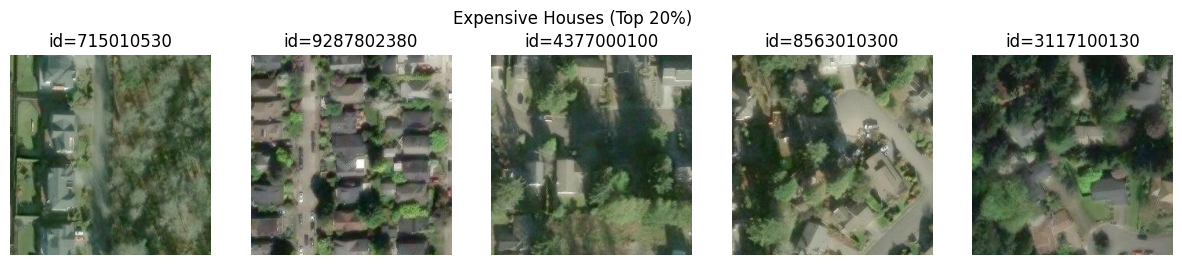

In [ ]:
show_images(cheap_df, "Cheap Houses (Bottom 20%)")
show_images(expensive_df, "Expensive Houses (Top 20%)")

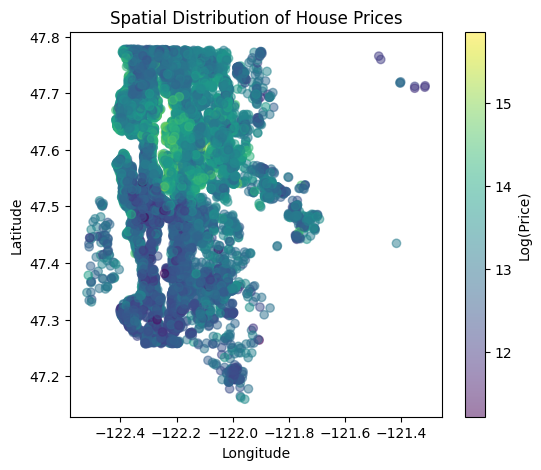

In [ ]:
plt.figure(figsize=(6,5))
# Visualize spatial variation of house prices using geographic coordinates
plt.scatter(
    df["long"],
    df["lat"],
    c=np.log1p(df["price"]),
    cmap="viridis",
    alpha=0.5
)
plt.colorbar(label="Log(Price)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of House Prices")
plt.show()

**Tabular Baseline Modeling**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Prepare tabular features and log-transformed target for model training
df = pd.read_csv("train.csv")

features = [
    "bedrooms",
    "bathrooms",
    "sqft_living",
    "sqft_lot",
    "floors",
    "waterfront",
    "view",
    "condition",
    "grade",
    "sqft_above",
    "sqft_basement",
    "lat",
    "long",
    "sqft_living15",
    "sqft_lot15"
]

X = df[features]
y = np.log1p(df["price"])


print(X.shape, y.shape)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

(16209, 15) (16209,)


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print("Linear Regression RMSE:", rmse)
print("Linear Regression R2:", r2)

Linear Regression RMSE: 0.2613536871951551
Linear Regression R2: 0.7524738678873305


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train a Random Forest model
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print("Random Forest RMSE:", rmse)
print("Random Forest R2:", r2)

Random Forest RMSE: 0.17842667392452619
Random Forest R2: 0.8846325344079953


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train an XGBoost model
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print("XGBoost RMSE:", rmse)
print("XGBoost R2:", r2)

XGBoost RMSE: 0.1675283840226165
XGBoost R2: 0.8982954011699579


**Visual Feature Extraction using CNNs**

In [ ]:
# Import libraries for image processing and deep learning
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# Define image preprocessing steps before feeding images to the model
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
# Custom dataset to load satellite images and their corresponding IDs
class SatelliteDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # return image and image id
        img_id = int(self.image_files[idx].replace(".png", ""))
        return image, img_id

In [ ]:
# Loading a pretrained ResNet model and using it only for feature extraction
resnet = models.resnet18(pretrained=True)

# Remove final classification layer
resnet.fc = torch.nn.Identity()

resnet = resnet.to(device)
resnet.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 153MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Create a DataLoader to load satellite images in batches
dataset = SatelliteDataset(
    image_dir="images/train",
    transform=image_transform
)

loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=False
)

In [ ]:
import torch

# Extract image feature vectors using the pretrained CNN and store them by image ID
image_embeddings = {}

with torch.no_grad():
    for images, img_ids in loader:
        images = images.to(device)

        features = resnet(images)  # shape: (batch, 512)
        features = features.cpu().numpy()

        for i, img_id in enumerate(img_ids):
            image_embeddings[int(img_id)] = features[i]

In [ ]:
import pandas as pd

# Convert extracted image features into a DataFrame for merging
emb_df = pd.DataFrame.from_dict(
    image_embeddings,
    orient="index"
)

emb_df.index.name = "id"
emb_df.reset_index(inplace=True)

emb_df.head()


,id,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,7347600490,1.255626,0.258319,3.118853,1.448309,2.133605,0.061878,1.385776,0.353652,0.787217,...,0.810081,0.944564,0.240610,0.034967,0.000000,0.112986,1.204052,1.763811,0.009334,0.219259
1,3814701090,0.998965,0.117463,2.058722,0.459339,1.266860,0.197850,0.817742,2.203235,0.942169,...,0.596421,0.790800,1.066381,0.620638,0.007647,0.922584,1.651392,2.925292,0.119602,0.524065
2,1445500100,0.607680,0.900147,0.809093,0.580476,0.216685,0.256459,0.316626,1.220612,0.763231,...,0.068898,0.395156,0.296662,0.326616,0.000000,0.605219,0.655076,0.942943,0.278430,0.000000
3,3022039069,2.065413,0.917108,2.437197,1.278270,0.950588,0.112954,0.264491,1.176968,2.284224,...,0.333874,3.376355,0.397742,0.288148,0.372872,0.598393,0.630421,3.266739,0.000000,0.058739
4,6821102385,1.384803,0.614815,4.335210,0.459552,0.647299,0.154015,1.425484,1.000852,1.909922,...,1.412972,1.833839,0.190766,0.171708,0.000000,0.173290,1.573487,0.847820,0.000000,0.101291


In [ ]:
emb_df.shape

(16110, 513)

**Multimodal Fusion & Regression Modeling**

In [ ]:
import pandas as pd
import numpy as np

# Prepare tabular features and log-transformed target for multimodal modeling
df = pd.read_csv("train.csv")

y = np.log1p(df["price"])

# selecting same tabular features as Phase 3
tab_features = [
    "bedrooms",
    "bathrooms",
    "sqft_living",
    "sqft_lot",
    "floors",
    "waterfront",
    "view",
    "condition",
    "grade",
    "sqft_above",
    "sqft_basement",
    "lat",
    "long",
    "sqft_living15",
    "sqft_lot15"
]

X_tab = df[["id"] + tab_features]

In [ ]:
# Check the shape of the image embedding DataFrame
emb_df.shape

(16110, 513)

In [ ]:
# merge on property id
X_merged = pd.merge(X_tab, emb_df, on="id", how="inner")

print("Merged shape:", X_merged.shape)

Merged shape: (16209, 528)


In [ ]:
# Removing ID column before training the model
X = X_merged.drop(columns=["id"])

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Training and evaluating the multimodal XGBoost model
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print("Multimodal RMSE:", rmse)
print("Multimodal R2:", r2)

Multimodal RMSE: 0.1738848759088916
Multimodal R2: 0.8904310721673517


**Model Explainability with Grad-CAM**

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Loading a pretrained ResNet model and set it to evaluation mode
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet18(pretrained=True)
model.eval()
model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
features = None
gradients = None

def forward_hook(module, input, output):
    global features
    features = output

def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

# Register hooks to capture feature maps and gradients for visualization (Grad-CAM)
target_layer = model.layer4
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

In [ ]:
# Generate a Grad-CAM heatmap for a given satellite image
def generate_gradcam(img_path):
    global features, gradients

    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    output = model(input_tensor)
    score = output[:, output.argmax(dim=1)]
    model.zero_grad()
    score.backward()

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    for i in range(features.shape[1]):
        features[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(features, dim=1).squeeze()
    heatmap = np.maximum(heatmap.cpu().detach().numpy(), 0)
    heatmap /= heatmap.max()

    return img, heatmap

In [ ]:
# Overlay the Grad-CAM heatmap on the original image for visualization
import cv2

def show_gradcam(img, heatmap):
    heatmap = cv2.resize(heatmap, img.size)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    img_np = np.array(img)
    superimposed = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(4,4))
    plt.imshow(superimposed)
    plt.axis("off")
    plt.show()

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


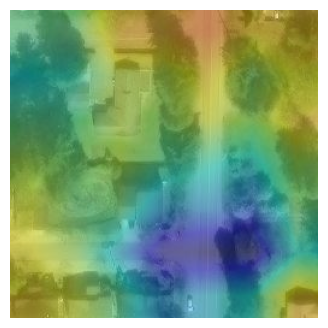

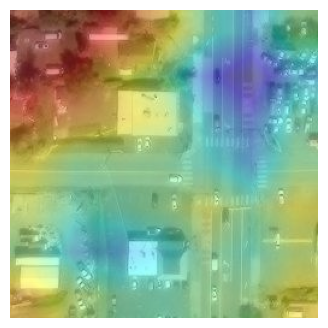

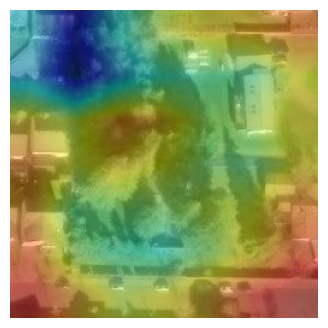

In [ ]:
# Generate and display Grad-CAM visualizations for a few sample images
sample_ids = [df.iloc[0]["id"], df.iloc[len(df)//2]["id"], df.iloc[-1]["id"]]

for hid in sample_ids:
    img_path = f"images/train/{int(hid)}.png"
    img, heatmap = generate_gradcam(img_path)
    show_gradcam(img, heatmap)

**Feature Importance**

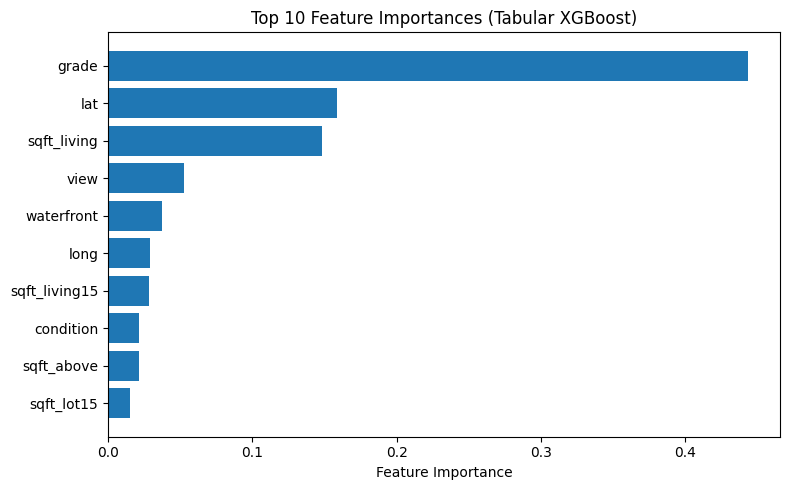

In [ ]:
# Plot the most important tabular features learned by the XGBoost model
import pandas as pd
import matplotlib.pyplot as plt

importance = xgb.feature_importances_

feat_importance = (
    pd.DataFrame({
        "feature": tab_features,
        "importance": importance
    })
    .sort_values(by="importance", ascending=False)
)

# Top 10 features
top_feats = feat_importance.head(10)

plt.figure(figsize=(8, 5))
plt.barh(top_feats["feature"], top_feats["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Top 10 Feature Importances (Tabular XGBoost)")
plt.tight_layout()
plt.show()

In [ ]:
import os
import cv2

# Saving the Grad-CAM visualization as an image file
os.makedirs("gradcam_outputs", exist_ok=True)

def save_gradcam(img, heatmap, save_path):
    heatmap = cv2.resize(heatmap, img.size)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    img_np = np.array(img)
    superimposed = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    cv2.imwrite(save_path, cv2.cvtColor(superimposed, cv2.COLOR_RGB2BGR))

In [ ]:
# Generating and saving Grad-CAM visualizations for a few sample images
sample_ids = [
    df.iloc[0]["id"],
    df.iloc[len(df)//2]["id"],
    df.iloc[-1]["id"]
]

for hid in sample_ids:
    img_path = f"images/train/{int(hid)}.png"
    img, heatmap = generate_gradcam(img_path)

    save_path = f"gradcam_outputs/gradcam_{int(hid)}.png"
    save_gradcam(img, heatmap, save_path)

**Predicting the price**

In [ ]:
# Generating final price predictions on the test set and saving them to a CSV file
import pandas as pd
import numpy as np

test_df = pd.read_csv("test.csv")

feature_cols = [
    "bedrooms",
    "bathrooms",
    "sqft_living",
    "sqft_lot",
    "floors",
    "waterfront",
    "view",
    "condition",
    "grade",
    "sqft_above",
    "sqft_basement",
    "lat",
    "long",
    "sqft_living15",
    "sqft_lot15"
]

X_test = test_df[feature_cols]

y_test_pred_log = xgb.predict(X_test)
y_test_pred_price = np.expm1(y_test_pred_log)

submission = pd.DataFrame({
    "id": test_df["id"],
    "predicted_price": y_test_pred_price
})

submission.to_csv("25572007_final.csv", index=False)

print("Saved 25572007_final.csv")
print(submission.shape)
submission.head()

Saved 25572007_final.csv
(5404, 2)


,id,predicted_price
0,2591820310,3.652099e+05
1,7974200820,9.781468e+05
2,7701450110,1.118574e+06
3,9522300010,1.802344e+06
4,9510861140,7.176824e+05
